## The notebook is performs the following actions:

### 1. File Statistics & Plotting: scans the classified_output directory, generates the filename lists, counts the files in each subfolder, and creates a bar plot of the counts.

### 2. Metadata Matching: loads the filenames_*.txt lists created in the previous step, loads the ctd_meta_v4.csv file, and matches every image to its closest sampling event using pandas.

#### Created by: E. Montes (enrique.montes@noaa.gov)
#### Date: November 5th 2025

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import for date formatting
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from pathlib import Path
from tqdm import tqdm  # For progress bars
import numpy as np
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

### Scan Subdirectories and Generate Filename Lists

### This cell iterates through each subfolder in classified_output. For each one, it counts the number of .png files and writes those filenames to a new .txt file (e.g., filenames_acantharea.txt).

In [ ]:
# Define the main directory
base_dir = Path("classified_output/")
category_counts = {}

print(f"Scanning directory: {base_dir.resolve()}")

# Find all subdirectories
# We assume any directory inside 'classified_output' is a category
subdirs = [d for d in base_dir.iterdir() if d.is_dir()]

for category_dir in tqdm(subdirs, desc="Processing categories"):
    category_name = category_dir.name
    
    # Find all .png files recursively in the category directory
    png_files = list(category_dir.rglob("*.png"))
    
    # Store the count
    category_counts[category_name] = len(png_files)
    
    # Define the output .txt filename
    output_txt_file = base_dir / f"filenames_{category_name}.txt"
    
    # Write the basenames (e.g., '20250127_175115.761.0.png') to the file
    with open(output_txt_file, 'w') as f:
        for file_path in png_files:
            f.write(f"{file_path.name}\n")

print("\nScan complete. Filename lists and counts generated.")

### Generate Statistics

In [ ]:
# Convert the dictionary of counts to a DataFrame
counts_df = pd.DataFrame(
    list(category_counts.items()), 
    columns=['Category', 'FileCount']
)

# Sort the DataFrame by count in descending order
counts_df = counts_df.sort_values(by='FileCount', ascending=False)
# Calculate the total number of files
total_files = counts_df['FileCount'].sum()

print(f"Total number of files in classified_output/: {total_files}")
print("File Counts per Category:")
print(counts_df.to_string())

### Plot File Counts


In [ ]:
# Set plot style and size
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Create the bar plot
ax = sns.barplot(
    data=counts_df, 
    x='Category', 
    y='FileCount', 
    palette="viridis"
)

# Set y-axis to log scale
ax.set_yscale('log')

plt.title('Number of PNG Files per Category (Log Scale)', fontsize=16)
plt.ylabel('Number of .png Files (Log Scale)', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90, fontsize=10) # Rotate x-axis labels for readability

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot
# plot_filename = "category_file_counts.png"
# plt.savefig(plot_filename)
# print(f"\nBar plot saved to: {plot_filename}")

# Display the plot
plt.show()

### Create a list of filenames with associated categories

In [ ]:
# Load filename lists

all_filename_files = list(base_dir.glob("filenames_*.txt"))
all_images_df_list = []

for file in all_filename_files:
    # Extract category name from the filename
    category_name = file.stem.replace("filenames_", "")
    
    # Read the text file
    temp_df = pd.read_csv(file, header=None, names=['filename'])
    temp_df['category'] = category_name
    all_images_df_list.append(temp_df)

# Combine all DataFrames into one
master_images_df = pd.concat(all_images_df_list, ignore_index=True)

print(f"Loaded a total of {len(master_images_df)} filenames from {len(all_filename_files)} category lists.")
master_images_df.head()

### Use this cell to perform actions above but using lists in TS.Master. To use TS.Master data, DO NOT RUN THE PREVIOUS CELLS (except for libraries) 

In [2]:
# --- 1. Define the directory path ---
# This path is from your R script's 'dir_path' variable
dir_path = Path("TS.Master/")

# --- 2. Find all the text files ---
print(f"Loading data from: {dir_path}")
file_paths = list(dir_path.glob("class.*.txt"))
if not file_paths:
    print(f"⚠️ Warning: No 'class.*.txt' files found in {dir_path}")
else:
    print(f"Found {len(file_paths)} 'class.*.txt' files.")

# --- 3. Create a list to hold all DataFrames ---
all_images_df_list = []

# --- 4. Loop over each file, load it, and extract data ---
for file in file_paths:
    # Get the category name from the filename
    # e.g., 'class.Chaetoceros.txt' -> 'Chaetoceros'
    category_name = file.stem.replace("class.", "")
    
    try:
        # Load the data. Assumes one column of long filenames
        temp_df = pd.read_csv(file, header=None, names=['long_filename'], sep="\t")
        
        # --- 5. Create the required columns ---
        # Extract the category name
        temp_df['category'] = category_name
        
        # Extract the short filename (the basename) from the long path
        # e.g., '20221206/20221206_1100/20221206_112525.241.0.png' -> '20221206_112525.241.0.png'
        temp_df['filename'] = temp_df['long_filename'].apply(lambda x: os.path.basename(x))
        
        # Add this category's data to our master list
        all_images_df_list.append(temp_df[['filename', 'category']])
        
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file: {file.name}")
    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# --- 6. Combine all DataFrames into one ---
master_images_df = pd.concat(all_images_df_list, ignore_index=True)

print(f"\nSuccessfully loaded a total of {len(master_images_df)} filenames from {len(file_paths)} category lists.")
print("Master image DataFrame created:")
print(master_images_df.head())

Loading data from: TS.Master
Found 27 'class.*.txt' files.

Successfully loaded a total of 26746 filenames from 27 category lists.
Master image DataFrame created:
                    filename    category
0  20221206_112525.241.0.png  Acantharea
1  20221209_050639.562.0.png  Acantharea
2  20221209_061336.138.0.png  Acantharea
3  20221209_062128.034.0.png  Acantharea
4  20221209_062230.633.0.png  Acantharea


### Parse Timestamps from Filenames

In [3]:
# Extract the timestamp string (e.g., '20250127_175115') from the filename
# We take the first 15 characters: YYYYMMDD_HHMMSS
master_images_df['datetime_str'] = master_images_df['filename'].str.slice(0, 15)

# Convert the string to a proper datetime object
# We use errors='coerce' to turn any parsing errors into NaT (Not a Time)
master_images_df['datetime'] = pd.to_datetime(
    master_images_df['datetime_str'], 
    format='%Y%m%d_%H%M%S', 
    errors='coerce',
    utc=True
)

# Sort by datetime, which is required for the merge
master_images_df = master_images_df.sort_values('datetime')

print("Successfully parsed datetimes from filenames:")
# Extract the minimum and maximum dates from the datetime column of master_images_df
min_date = master_images_df['datetime'].min()
max_date = master_images_df['datetime'].max()
print(f"Date range of classified images: {min_date} to {max_date}")
print(master_images_df[['filename', 'datetime']].head())

Successfully parsed datetimes from filenames:
Date range of classified images: 2022-12-04 01:05:11+00:00 to 2025-05-12 16:59:48+00:00
                        filename                  datetime
24627  20221204_010511.056.0.png 2022-12-04 01:05:11+00:00
18736  20221204_022956.586.0.png 2022-12-04 02:29:56+00:00
170    20221204_022959.191.1.png 2022-12-04 02:29:59+00:00
1459   20221204_023006.293.1.png 2022-12-04 02:30:06+00:00
171    20221204_023013.392.0.png 2022-12-04 02:30:13+00:00


### Load and Prepare CTD Metadata

In [4]:
ctd_meta_path = "ctd_meta_v4.csv"
ctd_df = pd.read_csv(ctd_meta_path)

# Combine year, month, day, and time into a single string
# We must ensure month and day are zero-padded
ctd_df['datetime_str'] = (
    ctd_df['year'].astype(str) + '-' +
    ctd_df['month'].astype(str).str.zfill(2) + '-' +
    ctd_df['day'].astype(str).str.zfill(2) + ' ' +
    ctd_df['time_gmt'].astype(str)
)

# Convert the string to a proper datetime object
# Format: %Y-%m-%d %I:%M:%S %p (e.g., 2022-12-06 1:00:00 PM)
ctd_df['GMT.datetime'] = pd.to_datetime(
    ctd_df['datetime_str'], 
    format='%Y-%m-%d %I:%M:%S %p',
    errors='coerce',
    utc=True
)

# Drop any rows where date conversion failed
ctd_df = ctd_df.dropna(subset=['GMT.datetime'])

# Sort by datetime, which is also required for the merge
ctd_df = ctd_df.sort_values('GMT.datetime')

print("\nSuccessfully loaded and parsed CTD metadata:")
print(ctd_df[['GMT.datetime', 'Station', 'cruiseID']].head())


Successfully loaded and parsed CTD metadata:
               GMT.datetime Station cruiseID
0 2022-12-04 01:01:00+00:00      68  WS22337
1 2022-12-04 02:27:00+00:00      65  WS22337
2 2022-12-04 03:23:00+00:00      64  WS22337
3 2022-12-04 04:45:00+00:00      60  WS22337
4 2022-12-04 06:35:00+00:00      58  WS22337


### Correct 'total_sampled_vol' by setting the sample_vol_per_min to a single, common value. This is to provide consistency in the calculation of plankton concentrations collected with different focus thresholds throughout the time series.

In [5]:
# Set sampled_vol_per_min to its maximum value (ignoring NaN)
ctd_df['sampled_vol_per_min'] = ctd_df['sampled_vol_per_min'].max(skipna=True)

# Set total_vol_sampled to common sampled_vol_per_min multiplied by conc_deployDurMin
ctd_df['total_vol_sampled'] = ctd_df['sampled_vol_per_min'].max(skipna=True) * ctd_df['conc_deployDurMin']

### Match Images to Metadata
### This finds the closest CTD timestamp for each image.

In [6]:
# Perform the merge. 
# 'direction=nearest' finds the absolute closest time in the CTD data.
# We also set a tolerance, e.g., 1 day, so images aren't matched
# to events weeks apart (optional, but good practice).
merged_df = pd.merge_asof(
    master_images_df, 
    ctd_df, 
    left_on='datetime', 
    right_on='GMT.datetime',
    direction='nearest',
    tolerance=pd.Timedelta('1 day')
)

print("Successfully merged image data with CTD metadata.")

# Display the first few rows of the merged data
print(merged_df[['filename', 'category', 'datetime', 'GMT.datetime', 'Station', 'cruiseID']].head())

Successfully merged image data with CTD metadata.
                    filename  category                  datetime  \
0  20221204_010511.056.0.png      TBD1 2022-12-04 01:05:11+00:00   
1  20221204_022956.586.0.png  Copepods 2022-12-04 02:29:56+00:00   
2  20221204_022959.191.1.png   Centric 2022-12-04 02:29:59+00:00   
3  20221204_023006.293.1.png    Chain2 2022-12-04 02:30:06+00:00   
4  20221204_023013.392.0.png   Centric 2022-12-04 02:30:13+00:00   

               GMT.datetime Station cruiseID  
0 2022-12-04 01:01:00+00:00      68  WS22337  
1 2022-12-04 02:27:00+00:00      65  WS22337  
2 2022-12-04 02:27:00+00:00      65  WS22337  
3 2022-12-04 02:27:00+00:00      65  WS22337  
4 2022-12-04 02:27:00+00:00      65  WS22337  


### List Unmatched Files
### This cell filters the merged_df to find all images that were not matched with any CTD data (e.g., they fell outside the tolerance window of any sampling event). It then saves this list to a text file for review.

In [7]:
print("Checking for unmatched files...")

# Find all rows where the merge failed. 
# We can check this by seeing where 'Station' (a column from ctd_df) is null (NaN).
unmatched_df = merged_df[merged_df['Station'].isnull()]

if unmatched_df.empty:
    print("\n✅ Success: All .png files were successfully matched to a sampling event.")
else:
    print(f"\n⚠️ Found {len(unmatched_df)} files that could not be matched to a sampling event.")
    
    # --- Save the full list to a file for review ---
    unmatched_output_file = "unmatched_files.txt"
    try:
        with open(unmatched_output_file, 'w') as f:
            for filename in unmatched_df['filename']:
                f.write(f"{filename}\n")
        print(f"A complete list of all {len(unmatched_df)} unmatched filenames has been saved to: {unmatched_output_file}")
    except Exception as e:
        print(f"Error saving unmatched file list: {e}")

    # --- Display a sample of the unmatched files ---
    print("\nSample of unmatched files (first 20):")
    # Use to_string to print without the index
    print(unmatched_df['filename'].head(20).to_string(index=False))
    
    if len(unmatched_df) > 20:
        print(f"...and {len(unmatched_df) - 20} more.")

Checking for unmatched files...

✅ Success: All .png files were successfully matched to a sampling event.


### Aggregate Counts and Calculate Concentrations
### Computes the counts of each category per sampling event, calculates the concentration (counts / volume sampled), and merges these new dataframes into a final plotting_df.

In [8]:
print("Aggregating counts per sampling event...")

# --- 1. Prepare `merged_df` for aggregation ---
# Copy the relevant data and ensure key columns are strings
agg_df = merged_df[['cruiseID', 'Station', 'category', 'total_vol_sampled']].copy()
agg_df['cruiseID'] = agg_df['cruiseID'].astype(str)
agg_df['Station'] = agg_df['Station'].astype(str)

# --- 2. Calculate Counts ---
# Group by the string keys and category, then count images
event_category_counts = agg_df.groupby(['cruiseID', 'Station', 'category']).size()

# Unstack to create the counts DataFrame (categories as columns)
counts_per_event_df = event_category_counts.unstack(level='category', fill_value=0)
counts_with_suffix_df = counts_per_event_df.add_suffix('_count')

# --- 3. Prepare `ctd_df` for plotting ---
# This will be our main plotting DataFrame
plotting_df = ctd_df.copy()

# Ensure the same key columns are strings for the merge
plotting_df['cruiseID'] = plotting_df['cruiseID'].astype(str)
plotting_df['Station'] = plotting_df['Station'].astype(str)

# Create the unique event index
plotting_df = plotting_df.drop_duplicates(subset=['cruiseID', 'Station']).set_index(['cruiseID', 'Station'])

# --- 4. Merge Counts into Plotting DataFrame ---
# Merge the counts we just calculated into the main plotting DataFrame
plotting_df = plotting_df.merge(
    counts_with_suffix_df, 
    left_index=True, 
    right_index=True, 
    how='left'
)

# --- 5. Calculate Concentrations ---
# Get a list of all the new '_count' columns
count_columns = [col for col in plotting_df.columns if col.endswith('_count')]

# Loop through each count column and create a corresponding '_conc' column
for col in count_columns:
    conc_col_name = col.replace('_count', '_conc')
    plotting_df[conc_col_name] = plotting_df[col] / (plotting_df['total_vol_sampled'] / 1e6) # Convert sampled volume to cubic meters 

# --- 6. Final Cleanup ---
# Filter out rows where total_vol_sampled is 0
plotting_df = plotting_df[plotting_df['total_vol_sampled'] > 0]
# Reset the index so 'cruiseID' and 'Station' are columns again
plotting_df.reset_index(inplace=True)

# --- 7. Final Check ---
print("Successfully created 'plotting_df' with counts and concentrations.")
print(f"Plotting DataFrame shape: {plotting_df.shape}")

# Check the sum of all counts to prove it's no longer zero
total_counts = plotting_df[count_columns].sum().sum()
print(f"Total counts aggregated in table: {total_counts}")

print("\nSample of the final plotting_df (first 5 rows, selected columns):")
# Filter for columns that actually exist to show a sample
sample_cols = [
    'cruiseID', 'Station', 'total_vol_sampled', 
] + [col for col in plotting_df.columns if '_count' in col or '_conc' in col]

print(plotting_df[sample_cols].head())

Aggregating counts per sampling event...
Successfully created 'plotting_df' with counts and concentrations.
Plotting DataFrame shape: (1015, 81)
Total counts aggregated in table: 26671.0

Sample of the final plotting_df (first 5 rows, selected columns):
  cruiseID Station  total_vol_sampled  Acantharea_count  Centric_count  \
0  WS22337      68           2214.810               0.0            0.0   
1  WS22337      65           1162.302               0.0            2.0   
2  WS22337      64              7.572               NaN            NaN   
3  WS22337      60           1855.140               0.0            5.0   
4  WS22337      58           2411.682               0.0            0.0   

   Ceratium_count  Chaetoceros_count  Chaetognaths_count  Chain2_count  \
0             0.0                0.0                 0.0           0.0   
1             0.0                0.0                 0.0           1.0   
2             NaN                NaN                 NaN           NaN   
3    

### Filter Plotting DataFrame by Image Date Range
### This cell filters the main plotting_df to create a clean_plotting_df. The new table will only contain cruise events that occurred within the time range of the classified images (from the master_images_df).

In [9]:
print("Filtering plotting_df by the date range of the classified images...")

# 1. Get the min and max datetimes from the master image list.
if master_images_df['datetime'].isnull().all():
    print("⚠️ Error: No valid datetimes found in the image list. Cannot filter by date.")
    # Create an empty df to avoid errors in the next cell
    clean_plotting_df = pd.DataFrame(columns=plotting_df.columns)
else:
    min_image_date = master_images_df['datetime'].min()
    max_image_date = master_images_df['datetime'].max()

    print(f"Image Date Range Start: {min_image_date}")
    print(f"Image Date Range End:   {max_image_date}")

    # 2. Filter the main plotting_df (from Cell 2.7)
    # This keeps all cruise events that fall within our image date range.
    clean_plotting_df = plotting_df[
        (plotting_df['GMT.datetime'] >= min_image_date) &
        (plotting_df['GMT.datetime'] <= max_image_date)
    ].copy()

    # Add zeros to cells with "Missing values" for counts and concentrations
    count_columns = [col for col in clean_plotting_df.columns if '_count' in col]
    conc_columns = [col for col in clean_plotting_df.columns if '_conc' in col]
    clean_plotting_df[count_columns] = clean_plotting_df[count_columns].fillna(0)
    clean_plotting_df[conc_columns] = clean_plotting_df[conc_columns].fillna(0)

    print(f"\nCreated 'clean_plotting_df' with {len(clean_plotting_df)} events.")
    print("This table contains all cruise events that occurred during the image time period:")
    
    # Show the cruises found within this time range
    cruises_in_range = clean_plotting_df['cruiseID'].unique()
    print(f"Found {len(cruises_in_range)} cruise(s) in this date range: {cruises_in_range}")
    
    print("\nSample of 'clean_plotting_df':")
    print(clean_plotting_df[['cruiseID', 'Station', 'GMT.datetime']].head())

Filtering plotting_df by the date range of the classified images...
Image Date Range Start: 2022-12-04 01:05:11+00:00
Image Date Range End:   2025-05-12 16:59:48+00:00

Created 'clean_plotting_df' with 889 events.
This table contains all cruise events that occurred during the image time period:
Found 15 cruise(s) in this date range: ['WS22337' 'WS23011' 'WS23061' 'H23138' 'WS23203' 'WS23259' 'HG23314'
 'HG24013' 'HG24062' 'WS24205' 'WS24258' 'WS24314' 'WS25024' 'HG25083'
 'WS25130']

Sample of 'clean_plotting_df':
  cruiseID Station              GMT.datetime
1  WS22337      65 2022-12-04 02:27:00+00:00
2  WS22337      64 2022-12-04 03:23:00+00:00
3  WS22337      60 2022-12-04 04:45:00+00:00
4  WS22337      58 2022-12-04 06:35:00+00:00
5  WS22337    57.3 2022-12-04 08:17:00+00:00


### Create a time series boxplot of concentrations for selected plankton groups

Preparing data for 'Copepods'...
Generating plot...


/tmp/ipykernel_1938757/1447180807.py:38: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  plot_data['plot_month'] = plot_data[date_col].dt.to_period('M').dt.start_time


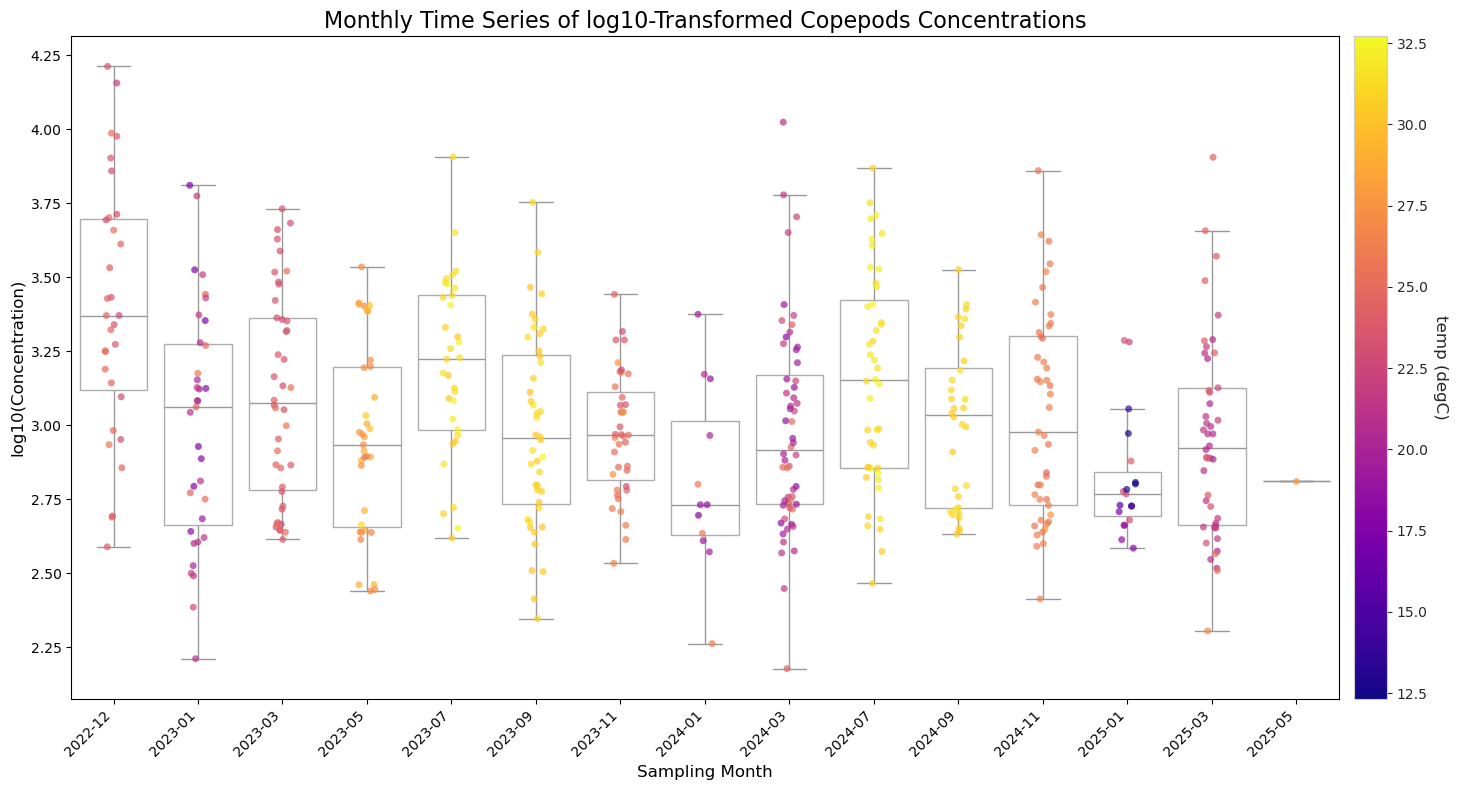

In [10]:
# --- 1. CONFIGURATION: Select Your Category ---
# Change this string to plot a different category
# The name must match the base name in the 'plotting_df' columns
SELECTED_CATEGORY = 'Copepods'
# -----------------------------------------------

# --- 2. Define Column Names ---
conc_col = f"{SELECTED_CATEGORY}_conc"
temp_col = 'temp (degC)'
date_col = 'GMT.datetime'

# --- 3. Check for Errors ---
if conc_col not in clean_plotting_df.columns:
    print(f"⚠️ Error: Column '{conc_col}' not found in clean_plotting_df.")
    print("Please check the 'SELECTED_CATEGORY' name and re-run.")
    print("Available categories include:", [col.replace('_conc', '') for col in clean_plotting_df.columns if col.endswith('_conc')])
elif temp_col not in clean_plotting_df.columns:
    print(f"⚠️ Error: Temperature column '{temp_col}' not found.")
else:
    # --- 4. Prepare Data for Plotting ---
    print(f"Preparing data for '{SELECTED_CATEGORY}'...")
    
    # Select only the necessary columns
    plot_data = clean_plotting_df[[date_col, conc_col, temp_col]].copy()

    # Filter out rows with zero concentration, as log(0) is undefined
    plot_data = plot_data[plot_data[conc_col] > 0]
    
    if plot_data.empty:
        print(f"No non-zero concentration data found for '{SELECTED_CATEGORY}'. Cannot generate plot.")
    else:
        # Create the log-transformed concentration
        plot_data['log_conc'] = np.log10(plot_data[conc_col])
        
        # --- Create a new column for the Month ---
        # This converts each date to the first day of its month (e.g., 2025-01-15 -> 2025-01-01)
        # This is now used for grouping the boxplots.
        plot_data['plot_month'] = plot_data[date_col].dt.to_period('M').dt.start_time
        
        # Sort by date for a clean time series axis
        plot_data = plot_data.sort_values('plot_month')

        # --- 5. Generate the Plot ---
        print("Generating plot...")
        fig, ax = plt.subplots(figsize=(16, 8))
        sns.set_style("whitegrid")
        
        # Layer 1: The Boxplots
        # Group by the new 'plot_month' column
        sns.boxplot(
            ax=ax,
            data=plot_data,
            x='plot_month',
            y='log_conc',
            color='white',
            fliersize=0,
            boxprops=dict(alpha=0.8)
        )
        
        # Layer 2: The Data Points
        # Also group by 'plot_month'
        points = sns.stripplot(
            ax=ax,
            data=plot_data,
            x='plot_month',
            y='log_conc',
            hue=temp_col,
            palette='plasma', # A good (blue-to-red) palette for temperature
            jitter=True,
            s=5,
            alpha=0.7,
            legend=False # We will create our own color bar
        )
        
        # --- 6. Create a Manual Color Bar for Temperature ---
        norm = plt.Normalize(plot_data[temp_col].min(), plot_data[temp_col].max())
        sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
        sm.set_array([])
        
        cbar = fig.colorbar(sm, ax=ax, pad=0.01)
        cbar.set_label(f'{temp_col}', rotation=270, labelpad=15, fontsize=12)

        # --- 7. Customize Plot ---
        plt.title(f"Monthly Time Series of log10-Transformed {SELECTED_CATEGORY} Concentrations", fontsize=16)
        plt.ylabel("log10(Concentration)", fontsize=12)
        plt.xlabel("Sampling Month", fontsize=12)
        
        # --- Format x-axis ticks for months ---
        # Get all unique months from our sorted data
        unique_months = sorted(plot_data['plot_month'].unique())
        
        # Set the tick positions and format labels as 'YYYY-MM'
        ax.set_xticks(range(len(unique_months)))
        ax.set_xticklabels([pd.to_datetime(date).strftime('%Y-%m') for date in unique_months])
        
        plt.xticks(rotation=45, horizontalalignment='right')
        plt.tight_layout()
        
        # Save the plot
        # plot_filename = f"{SELECTED_CATEGORY}_monthly_timeseries_boxplot.png"
        # plt.savefig(plot_filename)
        # print(f"\nMonthly time series plot saved to: {plot_filename}")

        # Display the plot
        plt.show()

### Compute the mean and standard deviation of concentrations for all categories, grouped by Station

In [11]:
print("Calculating mean and standard deviation of concentrations per station...")

# --- 1. Identify all concentration columns ---
conc_columns = [col for col in clean_plotting_df.columns if col.endswith('_conc')]

if not conc_columns:
    print("⚠️ Error: No concentration columns ('_conc') found in clean_plotting_df.")
else:
    # --- 2. Define columns to aggregate and aggregation rules ---
    
    # Columns we want to process
    columns_to_agg = ['Station', 'dec_lat', 'dec_lon'] + conc_columns
    
    # Create a copy and replace 0s with NaN in conc columns.
    # We make a copy to avoid changing 'clean_plotting_df' for later plots
    station_data = clean_plotting_df[columns_to_agg].copy()
    station_data[conc_columns] = station_data[conc_columns].replace(0, np.nan)
    
    # Create a dictionary of aggregation rules
    # For lat/lon, we only want the mean
    agg_rules = {
        'dec_lat': ['mean'],
        'dec_lon': ['mean']
    }
    
    # For concentration columns, we want both mean and std
    for col in conc_columns:
        agg_rules[col] = ['mean', 'std']

    # --- 3. Group by Station and Aggregate ---
    try:
        station_stats_df = station_data.groupby('Station').agg(agg_rules)

        # --- 4. Clean up the resulting DataFrame ---
        # The .agg() function creates a MultiIndex in the columns (e.g., ('Acantharea_conc', 'mean'))
        # This code "flattens" it to a single-level column (e.g., 'Acantharea_conc_mean')
        
        flat_cols = []
        for col_name, stat in station_stats_df.columns:
            # For lat/lon, the stat will just be 'mean', so we can name it 'dec_lat_mean'
            flat_cols.append(f"{col_name}_{stat}")
        
        station_stats_df.columns = flat_cols
        
        # Reset the index to make 'Station' a column again
        station_stats_df = station_stats_df.reset_index()

        # --- 5. Display the results ---
        print("\nSuccessfully calculated statistics per station:")
        
        # Move lat/lon to the front for easier reading
        cols = ['Station', 'dec_lat_mean', 'dec_lon_mean'] + \
               [col for col in station_stats_df.columns if col not in ['Station', 'dec_lat_mean', 'dec_lon_mean']]
        station_stats_df = station_stats_df[cols]
        
        print(station_stats_df.head())

        # Save the statistics to a new CSV file
        # stats_output_file = "station_concentration_stats.csv"
        # station_stats_df.to_csv(stats_output_file, index=False)
        # print(f"\nStatistics table saved to: {stats_output_file}")

    except Exception as e:
        print(f"An error occurred during aggregation: {e}")

Calculating mean and standard deviation of concentrations per station...

Successfully calculated statistics per station:
  Station  dec_lat_mean  dec_lon_mean  Acantharea_conc_mean  \
0      10     24.786428    -80.861887                   NaN   
1      12     24.713658    -80.832275            439.012841   
2      13     24.700700    -81.031800                   NaN   
3      16     24.669886    -81.190450                   NaN   
4      18     24.598350    -81.182951            380.334290   

   Acantharea_conc_std  Centric_conc_mean  Centric_conc_std  \
0                  NaN                NaN               NaN   
1           154.231568                NaN               NaN   
2                  NaN                NaN               NaN   
3                  NaN                NaN               NaN   
4           109.505041                NaN               NaN   

   Ceratium_conc_mean  Ceratium_conc_std  Chaetoceros_conc_mean  ...  \
0                 NaN                NaN        

### Map Mean Concentrations and Standard Deviations

Generating static .png map...

Successfully saved static map to: station_concentration_map.png


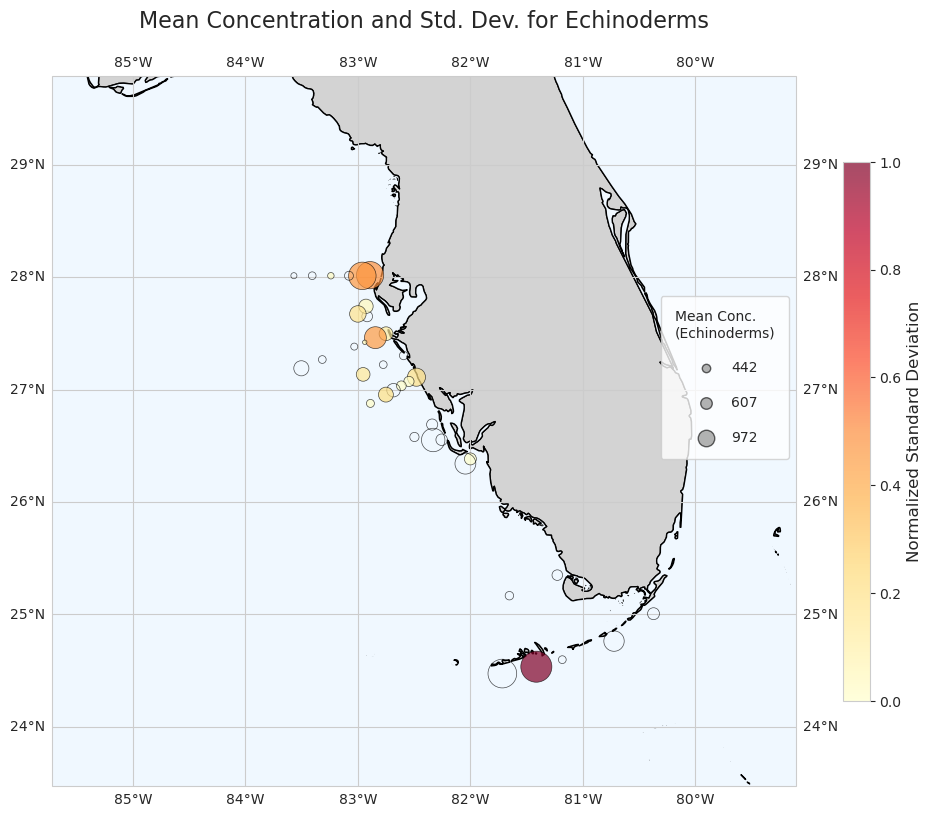

In [14]:
print("Generating static .png map...")

# --- 1. CONFIGURATION: Select Your Category ---
SELECTED_CATEGORY_FOR_MAP = 'Echinoderms'
# -----------------------------------------------

# --- 2. Define Column Names ---
mean_col = f"{SELECTED_CATEGORY_FOR_MAP}_conc_mean"
std_col = f"{SELECTED_CATEGORY_FOR_MAP}_conc_std"
lat_col = 'dec_lat_mean'
lon_col = 'dec_lon_mean'

# --- 3. Check for Errors ---
if mean_col not in station_stats_df.columns:
    print(f"⚠️ Error: Column '{mean_col}' not found in station_stats_df.")
    print("Please check the 'SELECTED_CATEGORY_FOR_MAP' name and re-run.")
else:
    # --- 4. Prepare Data for Plotting ---
    plot_map_df = station_stats_df.copy()
    
    # --- 5. Normalize Data for Plotting ---
    
    # a) Normalize Standard Deviation (for Color)
    max_std = plot_map_df[std_col].max()
    if max_std > 0:
        plot_map_df['std_normalized'] = plot_map_df[std_col] / max_std
    else:
        plot_map_df['std_normalized'] = 0.0
    
    # b) Normalize Mean Concentration (for Size)
    # matplotlib 's' (size) param is in points^2, so we scale it
    min_mean = plot_map_df[mean_col].min()
    max_mean = plot_map_df[mean_col].max()
    mean_range = max_mean - min_mean
    if mean_range == 0:
        mean_range = 1e-6
    
    # Scale size from 10 to 500
    base_size = 10
    max_size = 490
    plot_map_df['size_scaled'] = base_size + ((plot_map_df[mean_col] - min_mean) / mean_range) * max_size

    # --- 6. Create the Map ---
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    # --- 7. Set Map Extent (Zoom) ---
    pad = 1.0 # Padding in degrees
    min_lon = plot_map_df[lon_col].min() - pad
    max_lon = plot_map_df[lon_col].max() + pad
    min_lat = plot_map_df[lat_col].min() - pad
    max_lat = plot_map_df[lat_col].max() + pad
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # --- 8. Add Map Features ---
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='aliceblue')
    ax.add_feature(cfeature.COASTLINE, zorder=1)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    # --- 9. Plot the Data (Scatter Plot) ---
    cmap = 'YlOrRd'
    norm = Normalize(vmin=0, vmax=1) # Normalize color from 0 to 1
    
    sc = ax.scatter(
        x=plot_map_df[lon_col],
        y=plot_map_df[lat_col],
        s=plot_map_df['size_scaled'],
        c=plot_map_df['std_normalized'],
        cmap=cmap,
        norm=norm,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
        zorder=10
    )
    
    # --- 10. Add Colorbar (for Standard Deviation) ---
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.05)
    cbar.set_label('Normalized Standard Deviation', fontsize=12)
    
    # --- 11. Add Bubble Legend (for Mean Concentration) ---
    # We get 3 quantile values for the legend
    legend_values = plot_map_df[mean_col].quantile([0.25, 0.5, 0.75])
    legend_values = sorted(list(set(legend_values.dropna()))) # Drop NaNs if any
    # legend_values = [3000, 6000, 10000]  # Fixed values for better readability

    # Create scaled sizes for the legend
    legend_sizes = [base_size + ((v - min_mean) / mean_range) * max_size for v in legend_values]
    
    # Create "dummy" scatter plots just for the legend handles
    handles = []
    for size, value in zip(legend_sizes, legend_values):
        handles.append(plt.scatter([], [], s=size, label=f"{value:.0f}",
                                   color='gray', alpha=0.6, edgecolors='black'))
    
    ax.legend(
        handles=handles,
        title=f"Mean Conc.\n({SELECTED_CATEGORY_FOR_MAP})",
        loc='upper right',
        bbox_to_anchor=(1.0, 0.7), # Adjust position
        frameon=True,
        labelspacing=1.5,
        borderpad=1
    )

    # --- 12. Final Touches and Save ---
    ax.set_title(f'Mean Concentration and Std. Dev. for {SELECTED_CATEGORY_FOR_MAP}', fontsize=16, pad=20)
    map_filename = "station_concentration_map.png"
    # plt.savefig(map_filename, dpi=300, bbox_inches='tight')
    
    print(f"\nSuccessfully saved static map to: {map_filename}")
    
    # Display the plot
    plt.show()

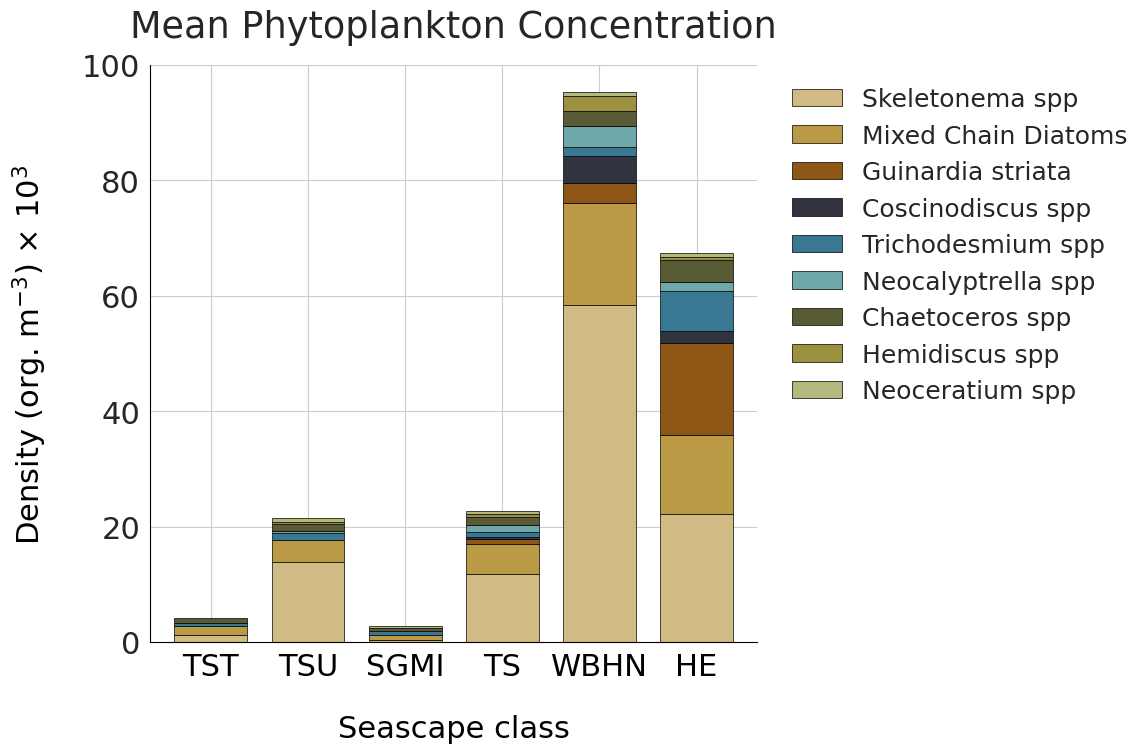

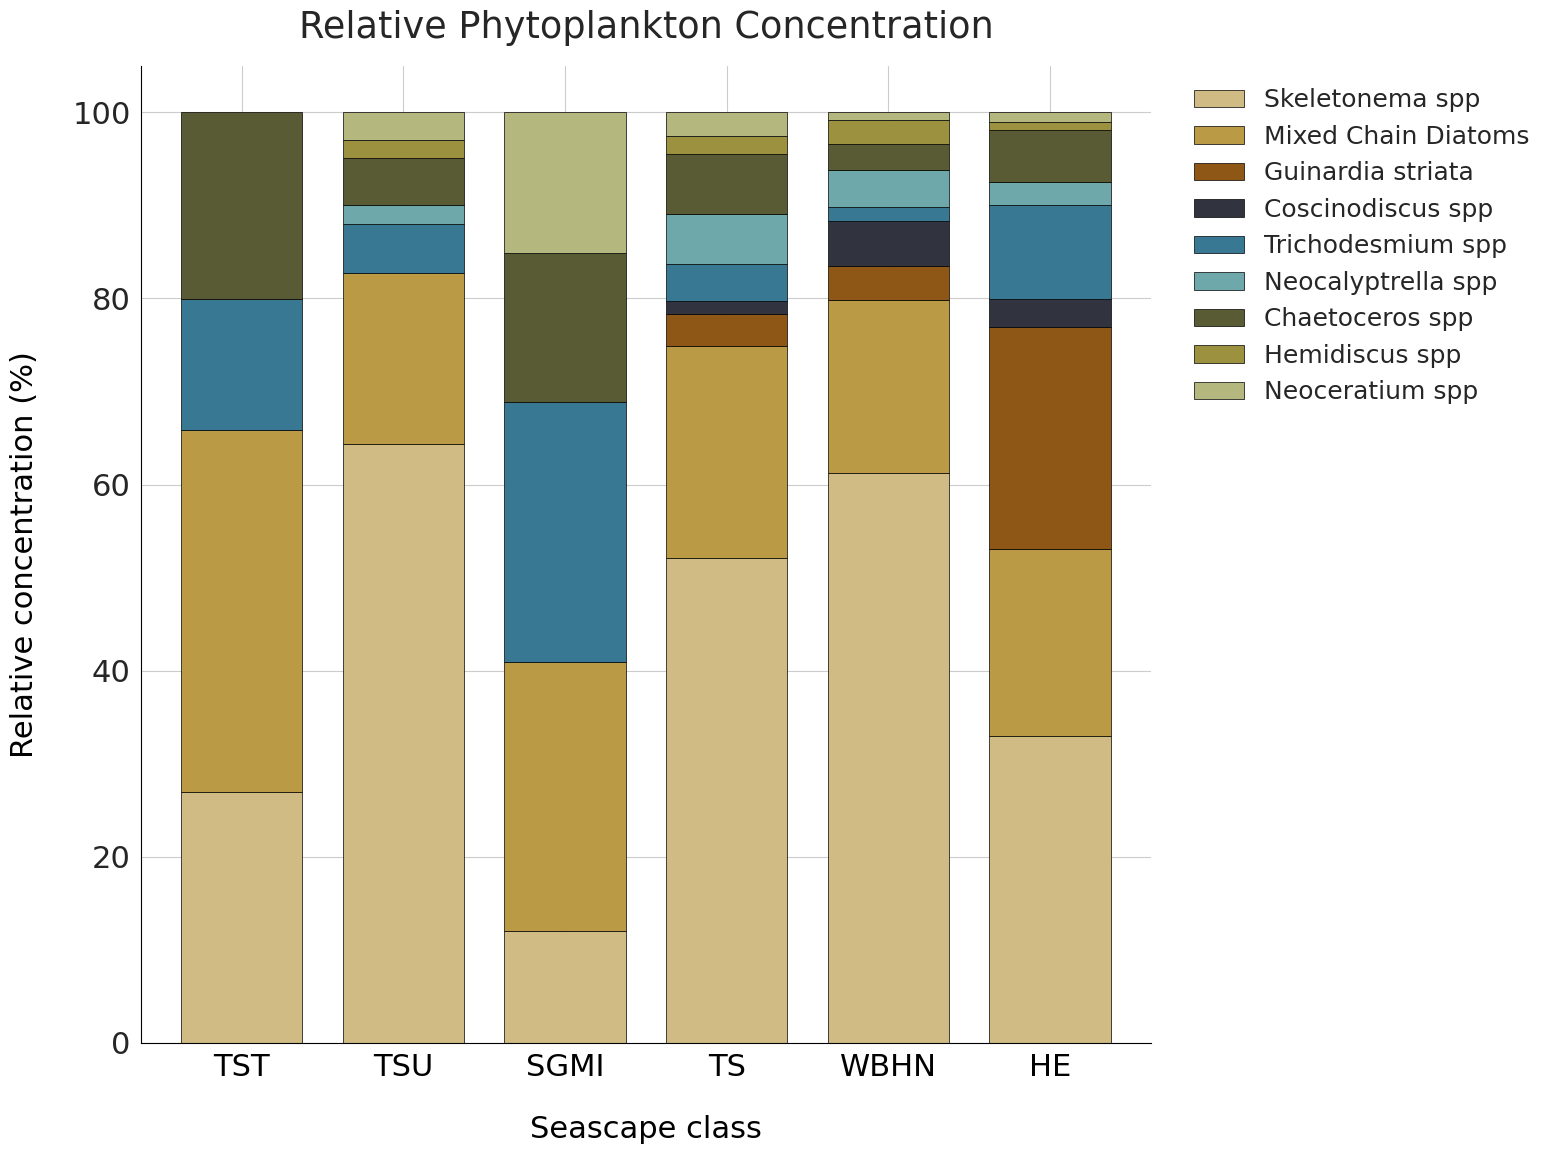

In [26]:
# Options: 'zooplankton' or 'phytoplankton'
group_to_plot = 'phytoplankton' 
# ----------------------------------

# 1. Define Groups, Mappings, and Colors
zooplankton_config = {
    "species": ["Acantharea", "Chaetognaths", "Copepods", "Decapods", "Echinoderms", 
                "Jellies", "Larvaceans", "Ostracods", "Polychaets", "Pteropods"],
    "rename": {"Polychaets": "Polychaetes", "Acantharea": "Acantharea spp", "Jellies": "Gelatinous"},
    "colors": ["#7992A6FF", "#C0D1CEFF", "#32B2DAFF", "#6AD5E8FF", "#C3F4F6FF", 
               "#FFF179FF", "#F5B642FF", "#DF7700FF", "#889D35FF", "#551F00FF"] 
}

phytoplankton_config = {
    "species": ["Centric", "Ceratium", "Chaetoceros", "Chain2", "Chain3", 
                "Guinardia", "Neocalyptrella", "Noctiluca", "Tricho"],
    "rename": {
        "Noctiluca": "Hemidiscus spp", "Ceratium": "Neoceratium spp", "Tricho": "Trichodesmium spp",
        "Neocalyptrella": "Neocalyptrella spp", "Chaetoceros": "Chaetoceros spp", "Centric": "Coscinodiscus spp",
        "Guinardia": "Guinardia striata", "Chain2": "Mixed Chain Diatoms", "Chain3": "Skeletonema spp"
    },
    "colors": ["#CFBB83FF", "#BA9A44FF", "#8F5715FF", "#31333FFF", "#397893FF", 
               "#6EA8ABFF", "#585B33FF", "#9C913FFF", "#B4B87FFF"] 
}

# Select configuration based on choice
config = zooplankton_config if group_to_plot == 'zooplankton' else phytoplankton_config
species_list = config["species"]
conc_cols = [f"{sp}_conc" for sp in species_list]

# 2. Subset and Filter Data
# Note: Use '8-day seascapes' to match CSV column name
cols_to_keep = ['8-day seascapes', 'total_vol_sampled', 'GMT.datetime'] + conc_cols
spp_df = clean_plotting_df[cols_to_keep].copy().dropna(subset=['8-day seascapes', 'total_vol_sampled'])

# Filter for specific seascape classes
seascape_levels = [3.0, 11.0, 13.0, 15.0, 21.0, 27.0]
spp_df = spp_df[spp_df['8-day seascapes'].isin(seascape_levels)]

# 3. Processing: Calculate Mean Concentration
spp_conc_long = spp_df.melt(
    id_vars=['8-day seascapes', 'GMT.datetime'], 
    value_vars=conc_cols, 
    var_name='species', value_name='concentration'
)
spp_conc_long['species'] = spp_conc_long['species'].str.replace('_conc', '')

# Filter concentration > 0 and calculate mean (divide by 1000 for scale)
avg_concentration = spp_conc_long[spp_conc_long['concentration'] > 0].groupby(['8-day seascapes', 'species']).agg(
    mean_concentration=('concentration', lambda x: x.mean() / 1000)
).reset_index()

# 4. Sorting: Highest Abundance at Bottom (Descending)
species_order = (avg_concentration.groupby('species')['mean_concentration']
                 .mean()
                 .sort_values(ascending=False) 
                 .index.tolist())

# Prepare Plotting Labels
seascape_labels = {3.0: "TST", 11.0: "TSU", 13.0: "SGMI", 15.0: "TS", 21.0: "WBHN", 27.0: "HE"}
spp_labels = [config["rename"].get(s, s) for s in species_order]

# 5. Prepare Pivot Tables for Plotting
pivot_df = avg_concentration.pivot(index='8-day seascapes', columns='species', values='mean_concentration')
pivot_df = pivot_df.reindex(seascape_levels)[species_order] # Order X and Stack
percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# 6. Plotting
font_size = 22
plt.rcParams.update({'font.size': font_size})

# Figure 1: Average Concentration Stacked Plot
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax, color=config["colors"], width=0.75, edgecolor='black', linewidth=0.5)

ax.set_xticklabels([seascape_labels[x] for x in seascape_levels], rotation=0, color="black")
ax.set_ylabel(r'Density (org. m$^{-3}$) $\times$ 10$^{3}$', labelpad=24, color="black")
ax.set_xlabel('Seascape class', labelpad=24, color="black")
ax.set_ylim(0, 100) # As specified in R: ylim(0, 100)
ax.legend(spp_labels, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=font_size-4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.title(f'Mean {group_to_plot.capitalize()} Concentration', pad=20)
plt.tight_layout()
plt.show()

# Figure 2: Relative Concentration (%) Stacked Plot
fig, ax = plt.subplots(figsize=(16, 12))
percent_df.plot(kind='bar', stacked=True, ax=ax, color=config["colors"], width=0.75, edgecolor='black', linewidth=0.5)

ax.set_xticklabels([seascape_labels[x] for x in seascape_levels], rotation=0, color="black")
ax.set_ylabel('Relative concentration (%)', labelpad=24, color="black")
ax.set_xlabel('Seascape class', labelpad=24, color="black")
ax.legend(spp_labels, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=font_size-4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.title(f'Relative {group_to_plot.capitalize()} Concentration', pad=20)
plt.tight_layout()
plt.show()